<h1>Demo application of Grover's Algorithm on a 2x2 Sudoku with 2 bit colors</h1

<h3>Imports</h3>

In [1]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
import numpy as np

<h3>Define the edges between the nodes</h3>

In [29]:
"""the example graph has 4 field/nodes where the numbers are given from top left (0) to top right (1), bottom left (2) to bottom right (3)"""
#set a list of tupel of qubits that are not allowed to be the same
tupel_list = [(0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

<h3>Set helper functions

In [30]:
#this function adds the getes needed to flip the output bit to the correct state (0 if 2x2 bits are equal else 1)
#this could be also done with 6 insted of 8 gates but then you need to add another n bits for each node where n ist the number of bits used to encode color
#would be interesting to change at scale (more bits vs. more gates)
def flipper(qc, x, y, o):
    #prepare the two variables for the position in the register as we are using two bit encoded colors
    x_1, x_2 = x*2, x*2+1
    y_1, y_2 = y*2, y*2+1
    qc.cx(x_1, o)
    qc.cx(x_2, o)
    qc.cx(y_1, o)
    qc.cx(y_2, o)
    qc.ccx(x_1, x_2, o)
    qc.ccx(y_1, y_2, o)
    qc.ccx(x_1, y_2, o)
    qc.ccx(x_2, y_1, o)

In [31]:
#copied this from qiskit documentation
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "Grover"
    return U_s

In [33]:
#create separate registers for input and comparison states
in_qubits = QuantumRegister(8, name="i")
compare_qubits = QuantumRegister(len(tupel_list), name="c")
out_qubit = QuantumRegister(1, name="o")
classical_bits = ClassicalRegister(8, name="classic")
qc = QuantumCircuit(in_qubits, compare_qubits, out_qubit, classical_bits)

def graph_coloring_oracle(qc, tupel_list, compare_qubits):
    #perform the conditional xors
    for index, t in enumerate(tupel_list):
        flipper(qc, t[0], t[1], compare_qubits[index])

    #flip the output qubit if all compare qubits are 1
    qc.mct(compare_qubits, out_qubit)

    #uncompute the conditional xors
    for index, t in enumerate(tupel_list):
        flipper(qc, t[0], t[1], compare_qubits[index])

#init the output qubit to state | - >
# qc.initialize([1, -1]/np.sqrt(2), out_qubit)
qc.initialize([0, 1], out_qubit)
qc.h(out_qubit)
#init the input qubits for the first node
qc.initialize([1, 0], in_qubits[0])
qc.initialize([1, 0], in_qubits[1])
#second node
qc.initialize([0, 1], in_qubits[2])
qc.initialize([1, 0], in_qubits[3])

#init qubits in super position
qc.h(in_qubits[4:])
qc.barrier()

#performing the iterations
for _ in range(1):
    #perform the oracle
    graph_coloring_oracle(qc, tupel_list, compare_qubits)
    qc.barrier()
    #apply the diffuser
    qc.append(diffuser(4), [4, 5, 6, 7])
    qc.barrier()

#measure the input qubits
qc.measure(in_qubits, classical_bits)

qc.draw(fold=-1)

┌─────────────────┐      ░                                                                                                                                                                                                                                                                                                                                                                                                                       ░             ░ ┌─┐                     
      i_0: ┤ initialize(1,0) ├──────░───■─────────────────────────────■─────────■─────────■──────────────────────────────────■───────────────────■───────────────────────────────────────────────────────────────────────────────────────────────────■─────────────────────────────■─────────■─────────■──────────────────────────────────■───────────────────■─────────────────────────────────────────────────────────────────────────────────────────────░─────────────░─┤M├─────────────────────
           ├─────────────────┤      ░   │                             │         │         │                                  │                   │                                                                                                   │                             │         │         │                                  │                   │                                                                                             ░             ░ └╥┘┌─┐                  
      i_1: ┤ initialize(1,0) ├──────░───┼─────────■───────────────────■─────────┼────■────┼────■─────────────────────────────■───────────────────┼──────────────■────────────────────────────────────────────────────────────────────────────────────┼─────────■───────────────────■─────────┼────■────┼────■─────────────────────────────■───────────────────┼──────────────■──────────────────────────────────────────────────────────────────────────────░─────────────░──╫─┤M├──────────────────
           ├─────────────────┤      ░   │         │                   │         │    │    │    │                             │                   │              │                                                                                    │         │                   │         │    │    │    │                             │                   │              │                                                                              ░             ░  ║ └╥┘┌─┐               
      i_2: ┤ initialize(0,1) ├──────░───┼────■────┼───────────────────┼─────────┼────┼────┼────┼────────────────────────■────┼──────────────■────┼─────────■────┼─────────────────────────────■─────────■────────────────────────────────────────────┼────■────┼───────────────────┼─────────┼────┼────┼────┼────────────────────────■────┼──────────────■────┼─────────■────┼─────────────────────────────■─────────■──────────────────────────────────────░─────────────░──╫──╫─┤M├───────────────
           ├─────────────────┤      ░   │    │    │                   │         │    │    │    │                        │    │              │    │         │    │                             │         │                                            │    │    │                   │         │    │    │    │                        │    │              │    │         │    │                             │         │                                      ░             ░  ║  ║ └╥┘┌─┐            
      i_3: ┤ initialize(1,0) ├──────░───┼────┼────┼────■──────────────┼─────────┼────┼────┼────┼────────────────────────■────┼──────────────┼────┼────■────┼────┼────■────────────────────────■─────────┼────■───────────────────────────────────────┼────┼────┼────■──────────────┼─────────┼────┼────┼────┼────────────────────────■────┼──────────────┼────┼────■────┼────┼────■────────────────────────■─────────┼────■─────────────────────────────────░─────────────░──╫──╫──╫─┤M├────────────
           └──────┬───┬──────┘      ░   │    │    │    │              │         │    │    │    │                        │    │     

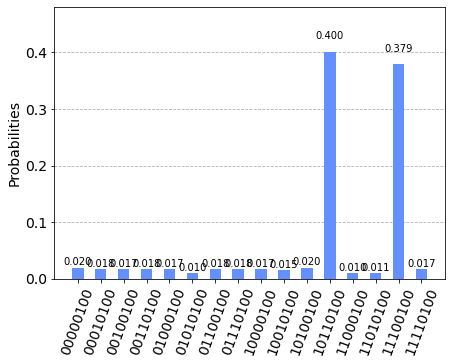

In [34]:
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
qobj = assemble(transpiled_qc)
result = qasm_simulator.run(qobj).result()
plot_histogram(result.get_counts())

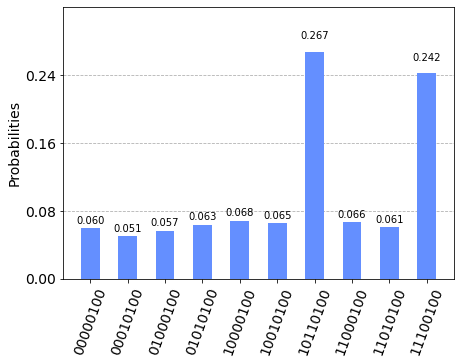

In [123]:
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())